# Convenience module for pytorch training

## Imports

In [1]:
import writefile_run

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%%writefile_run train_utils.py


"""
Convenience module for pytorch training and visualization.
"""

import torch
import torch.nn as nn
from torch import optim
from pylab import *
from torch.utils.data import *
from IPython.display import *
from nb_figure import *
import os, time
import traceback
from updaters import *

In [4]:
style.use(['dark_background'])
rcParams['axes.grid']=True
rcParams['font.size']=15
rcParams['figure.figsize']=18,7

# Helper functions

In [5]:
%%writefile_run train_utils.py -a


def getTimeName():
    """Return the current time in format <day>-<month>_<hour><minute> for use in filenames."""
    from datetime import datetime
    t = datetime.now()
    return "{:02d}-{:02d}_{:02d}{:02d}".format(t.day,t.month,t.hour,t.minute)

In [6]:
%%writefile_run train_utils.py -a


def save_as_txt(obj, filename):
    """Save str(obj) to the given filename. Overwrites file if it exists."""
    s = str(obj)
    with open(filename, 'w') as f:
        f.write(s)

In [7]:
%%writefile_run train_utils.py -a


def accuracy(scores, labels):
    """Return accuracy percentage. Assumes scores are in dim -1."""
    with torch.no_grad():
        total = scores.size()[0]
        pred = torch.argmax(scores, dim=-1)
        correct = (pred == labels).sum().cpu().numpy().astype('float32')
        acc = correct/total * 100
        return acc

In [8]:
%%writefile_run train_utils.py -a


def decorate_plot(axes):
    """Label x axis as Epoch for each axis"""
    for ax in axes.reshape(-1):
        ax.set_xlabel("Epoch")

# Trainer class

In [9]:
%%writefile_run train_utils.py -a


class Trainer():
    def __init__(self,
                 model,
                 trainOnBatch,
                 callback=None,
                 save_dir=None,
                 mode='nb'):
        """
        A trainer for training pytorch models.
        
        A top level directory given by save_dir is created, and the model architecture is saved.
        Every time loop is called, a run subdirectory is created and checkpoints are saved in that.
        
        The trainOnBatch function should perform the main train step, and return batch metrics.
        The optional callback can perform validation and return callback metrics.
        
        Make sure to call setup_metrics with names for each of the returned metrics in order.
        
        ---------
        Arguments
        ---------
        model: The model associated with this trainer
        trainOnBatch: a function with the following signature:
            trainOnBatch(model, batch, optimizer) -> tuple of batch metrics(scalars)
        callback: a function with the following signature:
            callback(model, val_loader) -> tuple of callback metrics(scalars)
        save_dir: the name of the directory to save all runs of this trainer in,
            if not provided, is the name of the model class
        mode: if 'nb', plot metric graphs and update displays, else just print info messages
        """
        
        
        if save_dir==None:
            save_dir=type(model).__name__    
        os.makedirs(save_dir,exist_ok=True)
        
        self.save_dir = save_dir
        self.trainOnBatch = trainOnBatch
        self.callback = callback
        self.mode = mode
        self.model = model
        self.has_displays = False
        
        # save model architecture
        save_as_txt(self.model, os.path.join(self.save_dir, 'arch.txt'))
        
        
    def save_model(self, epoch, directory):
        """Save the state dict of the model in the directory, 
        with the save name metrics at the given epoch."""
        # save state dict
        filename = "{}_epoch{:03d}".format(getTimeName(),epoch)
        
        for save_name_metric in self.save_name_metrics:
            filename = filename+"_{}{:.5f}".format(save_name_metric,
                                    self.metrics[save_name_metric][epoch-1])
        filename = filename+".statedict"
        
        torch.save(self.model.state_dict(), os.path.join(directory,filename))
    
    
    def setup_displays(self, batches, directory, **subplot_kwargs):
        """Set up IPython displays.
        
        batches: the number of batches in an epoch
        directory: the directory to save the metrics plot image
        """

        unique = str(time.time()) # string to make display ids unique
        
        # First line display
        self.batch_info = display(Markdown(''), display_id='batch_info'+unique)

        # Progress bar
        self.epoch_progress = ProgressBar(batches)
        self.progress_bar = display(self.epoch_progress,display_id='progress_bar'+unique)

        # Time of last epoch display
        self.time_info = display(Markdown(''), display_id='time_info'+unique)

        self.callback_info = display(Markdown(''), display_id='callback_info'+unique)

        # Last saved model
        self.checkpoint_info = display(Markdown(''), display_id='checkpoint_info'+unique)

        # Metric plots
        self.nbfig = NBFigure(os.path.join(directory,"metric_plots.png")
                              ,*self.fig_grid, decorate_plot, **subplot_kwargs)

        # setup lines 
        self.lines = {}
        for i,group in enumerate(self.plot_grouping):
            # add a single point line for each group to respective axis
            ax = self.nbfig.getAxis(i)
            for metric in group:
                self.lines[metric], = ax.plot([0],[0])

            ax.legend(group)

        self.nbfig.display()
        
        self.has_displays = True
        
        self.nbfig.update()

    def setup_metrics(self,
                      batch_metric_names, 
                      callback_metric_names=[], 
                      batch_metric_updaters=None,
                      save_name_metrics=None, 
                      fig_grid=(1,1),
                      plot_grouping=None):
        """
        Setup the metrics dict, with the given names for the metrics returned
        by the batch and callback functions. 
        
        ---------
        Arguments
        ---------
        batch_metric_names: names of the metrics returned by the trainOnBatch function, 
            in order
        callback_metric_names(=[]): names of the metrics returned by the callback function, 
            in order
        batch_metric_updaters(=None): A list of updaters for each of the batch metrics. The running 
            metric is displayed in the epoch update bar and is also stored. By default is the 
            'Latest' updater.
        plot_grouping(=None): a list of lists. Each list should contain the names of metrics to be 
            plotted in a single subplot. The index of each list corresponds to the index of
            the subplot, counted row major wise.
        save_name_metrics(=None): List of metric names which are added to the name of the saved 
            model checkpoints.
        fig_grid(=(1,1)): the number of rows and columns in the figure
           
        """
        
        # basic setups
        self.metrics = {}
        self.batch_metric_names = batch_metric_names
        self.callback_metric_names = callback_metric_names
        self.metric_names = self.batch_metric_names+self.callback_metric_names
        self.save_name_metrics = save_name_metrics if save_name_metrics != None else []
        
        if batch_metric_updaters != None:
            self.updaters = batch_metric_updaters
        else:
            self.updaters = [Latest() for m in self.batch_metric_names]
        
        # group all metrics into one if plot_grouping not specified
        if plot_grouping != None:
            self.plot_grouping = plot_grouping
        else:
            self.plot_grouping = [self.batch_metric_names+self.callback_metric_names]
        
        # initialize metric store
        for metric in self.metric_names:
            self.metrics[metric] = []
        
        self.fig_grid = fig_grid
        
        
    def update_metrics(self, batch_metrics, callback_metrics):
        """Update the stored lists for each metric with the given batch and callback metrics"""
        
        metrics = dict(zip(self.metric_names, batch_metrics+callback_metrics))
        for metric in self.metric_names:
            self.metrics[metric].append(metrics[metric])
        
        return metrics
        
    def update_lines(self, x_data):
        """Update the lines for each metric with the stored metric data, and the given x_data"""
        for metric in self.metric_names:
            self.lines[metric].set_data(x_data,self.metrics[metric])
            
        self.nbfig.update()
        
    def loop(self, 
             epochs, 
             train_loader, 
             optimizer, 
             val_loader=None, 
             update_interval=10, 
             save_every=1, 
             old_metrics=None, 
             new_displays = False):
        """
        Perform a train loop for the given number of epochs.
        
        First, the optimizer and dataset specs are saved in a run directory.
        
        For each epoch:
        
            trainOnBatch is called for each batch in train loader, and the running batch metrics 
            are updated using the given updaters in setup_metrics. The final resulting metrics are 
            recorded.

            callback is called after each epoch with the model and val_loader as inputs
            and the metrics it returns are also recorded.

            Plots of all metrics are updated live.

        Finally, model and optimzer state dicts are saved.
        
        Returns a dictionary containing the history of all recorded metrics.
        
        ---------
        Arguments
        ---------
        epochs: number of epochs to train for
        train_loader: data loader which provides batches which are fed into trainOnBatch
        optimizer: optimizer which is fed into trainOnBatch
        val_loader(optional): fed into callback as a keyword argument val_loader
        update_interval: number of batches to update displays after
        save_every: number of epochs after which to save model state dict
        """
        
        # setup metrics store
        for metric in self.metric_names:
            self.metrics[metric] = [] if old_metrics==None else old_metrics[metric][:]
            
        start_epoch = 0 if old_metrics==None else len(list(old_metrics.values())[0])
            
        # directory to save stuff
        run_dir = os.path.join(self.save_dir,"run_{}".format(getTimeName()))
        os.makedirs(run_dir,exist_ok=True)
        
        # display setup
        if self.mode == 'nb':
            if (self.has_displays == False) or (new_displays == True):
                self.setup_displays(len(train_loader), run_dir)
        
        # save optimizer spec
        save_as_txt(optimizer, os.path.join(run_dir,"optimizer_spec.txt"))
        
        # save dataset spec
        dataset_spec = "Train dataset:\n{}\nbatch size = {}\n".format(str(train_loader.dataset),
                                                                     train_loader.batch_size)
        if val_loader != None:
            dataset_spec += "Validation dataset:\n{}".format(str(val_loader.dataset))
        save_as_txt(dataset_spec, os.path.join(run_dir,"dataset_spec.txt"))
        
        # main train loop
        try:
            for e in range(start_epoch,start_epoch+epochs,1):

                i=0
                start = time.time()

                # Reset running metrics
                [updater.reset() for updater in self.updaters]
                
                for batch in train_loader:
                    # Perform train step
                    batch_metrics = self.trainOnBatch(self.model, batch, optimizer)
                    
                    # Update running metrics
                    batch_metrics = tuple([self.updaters[i].update(b_metric) 
                                           for i,b_metric in enumerate(batch_metrics)])
                    
                    # Update displays
                    i+=1
                    if i%update_interval==0:
                        toprint = "Epoch {}, batch {}, lr={:.6f}".format(e+1,i,
                                    optimizer.state_dict()['param_groups'][0]['lr'])
                        
                        for k,metric in enumerate(self.batch_metric_names):
                            toprint = toprint + ", {}={:.5f}".format(metric, batch_metrics[k])

                        if self.mode=='nb':
                            self.batch_info.update(Markdown(toprint))
                            self.epoch_progress.progress = i
                            self.progress_bar.update(self.epoch_progress)
                        else:
                            print(toprint)

                # Update time for epoch
                t = time.time()-start
                toprint = "Last epoch took {:.2f} seconds".format(t)
                if self.mode=='nb':
                    self.time_info.update(Markdown(toprint))
                else:
                    print(toprint)

                # execute callback
                callback_metrics = ()
                if self.callback != None:
                    callback_metrics = self.callback(self.model, val_loader=val_loader)
                    
                    # update display
                    toprint = "Callback metrics:<br>"
                    for k,metric in enumerate(self.callback_metric_names):
                        toprint = toprint + "{}={:.5f}<br>".format(metric, callback_metrics[k])
                    
                    if self.mode == 'nb':
                        self.callback_info.update(Markdown(toprint))
                    else:
                        print(toprint)
                
                x_data = arange(e+1)+1
                
                # Update metrics after each epoch
                metrics = self.update_metrics(batch_metrics, callback_metrics)
                
                # update plots
                if self.mode == 'nb':
                    self.update_lines(x_data)

                # Checkpointing
                if e%(save_every)==0:
                    # save the state dict
                    self.save_model(e+1, run_dir)
                    
                    # update display
                    toprint = "<br>Saved model after epoch {} on {} with following metrics:<br>".format(e+1
                                                                                    ,time.ctime())
                    for metric in self.metric_names:
                        toprint = toprint+"{}={:.5f}<br>".format(metric,metrics[metric])
                    
                    if self.mode == 'nb':
                        self.checkpoint_info.update(Markdown(toprint))
                    else:
                        print(toprint)

        except:
            print("Exception occured, saving model and metrics")
            traceback.print_exc()
        finally:
            # save model dict
            self.save_model(e, run_dir)
            
            # save metrics
            torch.save(self.metrics,
                  os.path.join(
                        run_dir,                
                        "{}_metrics_epoch{:03d}.dict".format(type(self.model).__name__,e+1)
                    )
                  )
            
            # save optimizer state
            torch.save(optimizer.state_dict(),
                  os.path.join(
                        run_dir,                
                        "optimizer_state_epoch{:03d}.statedict".format(e+1)
                    )
                  )
            
            return self.metrics

# Example workflow using the utils

Let's build a simple classifier for MNIST using the above utils to make our job easier.

## Get the data

The first step is to load the dataset and split into train, test and validation sets.

In [10]:
from torchvision.datasets import *
from torchvision.transforms import *

In [11]:
total_train_mnist = MNIST('/MNIST',download=True,transform=ToTensor())
test_mnist = MNIST('/MNIST',train=False,transform=ToTensor())

Splitting:

In [12]:
training_number = len(total_train_mnist)
val_split = 0.1

train_num = int(training_number*(1-val_split))
val_num = int(training_number*val_split)

train_mnist, val_mnist = torch.utils.data.dataset.random_split(total_train_mnist, 
                [train_num, val_num])

Let's make DataLoaders for each of the datasets with a batch size of $32$

In [13]:
train_loader = DataLoader(train_mnist, batch_size=32,shuffle=True)
val_loader = DataLoader(val_mnist, batch_size=32,shuffle=True)
test_loader = DataLoader(test_mnist, batch_size=32,shuffle=True)

## The model

Now, we create a bunch of modules and integrate them into a final model. Normally, there would be a heirarchy of many different modules, but for this simple example, we can make do with a single module.

In [14]:
import torch.nn.functional as F

In [15]:
class MnistClassifier(nn.Module):
    """A simple two layer fully connected neural network"""
    def __init__(self, hid_size):
        super(MnistClassifier, self).__init__()
        
        self.hidden_layer = nn.Linear(28*28,hid_size)
        
        self.output_layer = nn.Linear(hid_size,10)
        
        
    def forward(self, input):
        input = input.view(-1,28*28)
        
        out = F.relu(self.hidden_layer(input))
        out = self.output_layer(out)
        
        return out

## The train on batch function

Next, we have to write a function with the following signature:  

`trainOnBatch(model, batch, optimizer) -> tuple of metrics`  

This function is supposed to perform one training step on the model using the given optimizer and batch. Note that the format in which the data comes in through the batch can be specified by us, as we build our own `Dataset` classes and `DataLoader`s with custom collate functions for each application. The trainer utility only requires that this function take in the three arguments as shown above and return a tuple of scalar metrics.  

This function is called on each batch in the training `DataLoader` and the metrics it returns are updated each batch according to a set of running metric updaters. The final running metrics are recorded after each epoch and updated on the plot.

In [16]:
def trainOnBatch(model,batch,optimizer):
    
    # batch is tuple containing (tensor of images, tensor of labels)
    outputs = model(batch[0]) # forward pass
    
    # compute loss
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs,batch[1])
    
    # backward pass and weight update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # compute and return metrics
    loss = loss.detach().cpu().numpy()
    acc = accuracy(outputs, batch[1])
    
    return loss, acc

## The callback function

The next function which the trainer util uses is the `callback` function. It is an optional function, and its main purpose is for validation. Note that it can be used for other purposes like learning rate scheduling as well. The basic signature required is as follows:  

`callback(model, val_loader) -> tuple of callback metrics`

The `callback` receives the model instance and the validation `DataLoader`. It is expected to return a tuple of scalar callback metrics. This function is called at the end of every epoch of training, and the metrics it returns are recorded and plotted along with the running batch metrics recorded while training.

In [17]:
def callback(model, val_loader):
    with torch.no_grad(): # dont compute gradients
        criterion = nn.CrossEntropyLoss()
        
        model.eval() # eval mode
        
        batches = len(val_loader)
        loss=0
        acc=0
        for batch in val_loader:
            outputs = model(batch[0])
            loss += criterion(outputs,batch[1])
            acc += accuracy(outputs,batch[1])
        
        # find average loss and accuracy over whole vaildation set
        loss/= batches
        acc /= batches
        
        model.train() # go back to train mode
        
        # return metrics
        return loss.cpu().numpy(), acc

## The training

Now, we have defined all the functions we need for training our model. Let us first create an instance of our model with some parameters. Our simple model has only one parameter - the size of the hidden layer.

In [18]:
mnist_model = MnistClassifier(400)

Let's create an optimizer for training our model.

In [19]:
optimizer = optim.Adam(mnist_model.parameters())

Let's now build a trainer with all the stuff we have created above. The trainer `init` function requires a model, a `trainOnBatch`, and a `callback` function. The name of a top level save directory can also be optionally specified. If nothing is given, it is chosen as the class name of the given model instance. This save directory will have a text representation of the model architecture, and a folder for each training run of the model.

In [20]:
trainer = Trainer(mnist_model, trainOnBatch, callback=callback)

Before we can train our model, we need to provide specifications for the metrics it needs to track while training:

* We need to tell the trainer what metrics the `trainOnBatch` and `callback` functions return respectively. This is done by providing a list of names corresponding to the tuple of metrics returned by each of the functions respectively. Note that the order must match that returned by the functions.
* We also need to tell it how to take the running updates of the batch metrics as well. For this we provide a list of `Updaters`. Some common `Updaters` like averaging, running max and min, and a simple `Latest`(The latest sample is itself taken as the running metric) are provided in the `updaters` module. 
* We also need to specify which metrics are to be used in the save name of the checkpoints created during the training.
* The metrics will be plotted and updated live in the notebook. The trainer needs to know how many subplots to plot in the figure, and which metrics go on which plot. The `fig_grid` argument is used to specify the number of rows and columns in the grid of subplots.
* The `plot_grouping` describes which metrics are plotted on which subplot. Each element in this list corresponds to a subplot (indexed row major). Each element contains a list of metrics which are to plotted in this subplot.

In [21]:
trainer.setup_metrics(batch_metric_names=['loss','acc'], # trainOnBatch returns training loss and acc
                      callback_metric_names=['val_loss','val_acc'], # callback returns validation loss and acc
                      batch_metric_updaters=[Averager(), Averager()], # average the batch metrics over the epoch
                      save_name_metrics=['val_acc'], # Use the validation acc in checkpoint save names
                      fig_grid=(1,2), # 1 row, 2 cols
                      plot_grouping=[
                          ['loss','val_loss'], # first subplot for losses
                          ['acc','val_acc'] # second subplot for accuracies
                      ])

Now we have fully setup our trainer. We just need to call the loop function and provide the train and validation loaders and the optimizer.

Epoch 7, batch 1680, lr=0.001000, loss=0.01967, acc=99.37500

[=========================================================== ] 1680/1688

Last epoch took 11.90 seconds

Callback metrics:<br>val_loss=0.07580<br>val_acc=98.03856<br>

<br>Saved model after epoch 7 on Sat Jun 30 18:20:27 2018 with following metrics:<br>loss=0.01965<br>acc=99.37426<br>val_loss=0.07580<br>val_acc=98.03856<br>

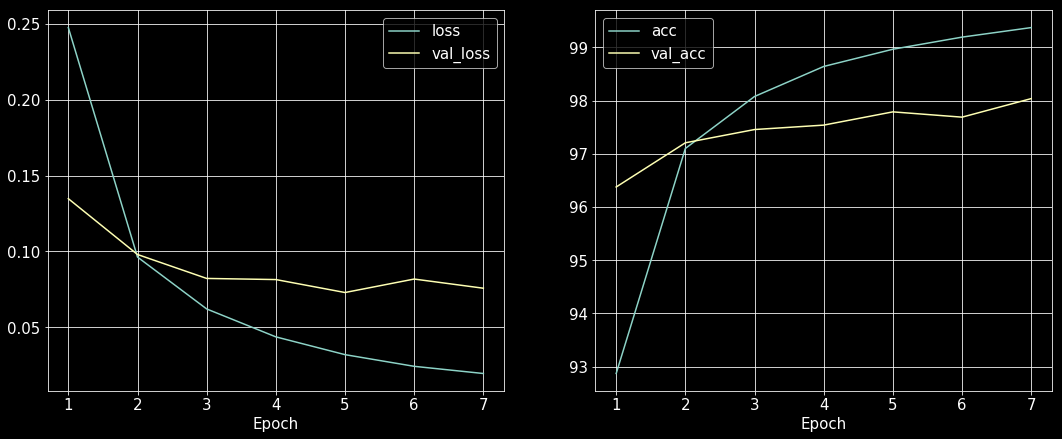

Finished this cell


In [22]:
metrics = trainer.loop(epochs=2, 
                       train_loader=train_loader,
                       optimizer=optimizer, 
                       val_loader=val_loader)
print("Finished this cell")

We can loop over the same model with mutliple calls to loop from the same trainer, but retaining the metrics and displays.

In [23]:
print("Starting this cell")
metrics = trainer.loop(epochs=5, 
                       train_loader=train_loader,
                       optimizer=optimizer, 
                       val_loader=val_loader,
                       old_metrics=metrics,)

Starting this cell
